### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [4]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [5]:
# 讀取資料
imgs_train, points_train = load_data(dirname = './training/training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [8]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [10]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [11]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=20, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/20
27/27 [==============================] - 39s 473ms/step - loss: 0.0138 - val_loss: 0.0022

Epoch 00001: val_loss improved from inf to 0.00218, saving model to best_weights.h5
Epoch 2/20
27/27 [==============================] - 12s 453ms/step - loss: 0.0019 - val_loss: 0.0022

Epoch 00002: val_loss improved from 0.00218 to 0.00215, saving model to best_weights.h5
Epoch 3/20
27/27 [==============================] - 12s 426ms/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00215 to 0.00189, saving model to best_weights.h5
Epoch 4/20
27/27 [==============================] - 13s 469ms/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00189 to 0.00189, saving model to best_weights.h5
Epoch 5/20
27/27 [==============================] - 12s 435ms/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00189 to 0.00182, saving model to best_weights.h5
Epoch 6/20
27/27 [==============================] - 12

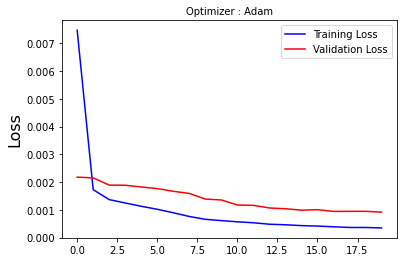

In [12]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [13]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = './test/test.csv')
print(imgs_test)
print(imgs_test.shape)
print(imgs_test.shape[0])

[[[0.7137255  0.7176471  0.7137255  ... 0.7137255  0.7137255  0.7137255 ]
  [0.7137255  0.70980394 0.70980394 ... 0.7137255  0.7137255  0.7137255 ]
  [0.7137255  0.70980394 0.7058824  ... 0.7137255  0.70980394 0.7137255 ]
  ...
  [0.16470589 0.14117648 0.07843138 ... 0.49411765 0.53333336 0.6       ]
  [0.12156863 0.03137255 0.         ... 0.03529412 0.04313726 0.12941177]
  [0.01176471 0.         0.00392157 ... 0.03137255 0.01960784 0.01960784]]

 [[0.29803923 0.34117648 0.31764707 ... 0.47058824 0.4509804  0.45882353]
  [0.26666668 0.33333334 0.32941177 ... 0.5176471  0.43529412 0.41568628]
  [0.24705882 0.30588236 0.32941177 ... 0.52156866 0.43137255 0.41568628]
  ...
  [0.34509805 0.3882353  0.5019608  ... 0.8666667  0.7058824  0.58431375]
  [0.35686275 0.38431373 0.4745098  ... 0.96862745 0.8666667  0.69803923]
  [0.39215687 0.43137255 0.49411765 ... 0.89411765 0.827451   0.65882355]]

 [[0.69411767 0.6901961  0.68235296 ... 0.44705883 0.43529412 0.43529412]
  [0.6901961  0.682352

In [14]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

[ 1.96497411e-01 -1.11280486e-01 -1.95132032e-01 -1.15785077e-01
  1.35088742e-01 -1.03128836e-01  2.71772176e-01 -1.04730427e-01
 -1.28066406e-01 -1.09827623e-01 -2.63077885e-01 -1.04672566e-01
  9.49739888e-02 -2.15137452e-01  3.40595275e-01 -1.95421755e-01
 -1.03800714e-01 -2.14088500e-01 -3.32551509e-01 -1.98597521e-01
 -6.99521042e-05  4.16793749e-02  1.54169083e-01  2.88730621e-01
 -1.54343396e-01  2.91747510e-01 -1.17226958e-03  2.11369500e-01
 -8.92972457e-05  3.77549946e-01]
[ 1.96497411e-01 -1.11280486e-01 -1.95132032e-01 -1.15785077e-01
  1.35088742e-01 -1.03128836e-01  2.71772176e-01 -1.04730427e-01
 -1.28066406e-01 -1.09827623e-01 -2.63077885e-01 -1.04672566e-01
  9.49739888e-02 -2.15137452e-01  3.40595275e-01 -1.95421755e-01
 -1.03800714e-01 -2.14088500e-01 -3.32551509e-01 -1.98597521e-01
 -6.99521042e-05  4.16793749e-02  1.54169083e-01  2.88730621e-01
 -1.54343396e-01  2.91747510e-01 -1.17226958e-03  2.11369500e-01
 -8.92972457e-05  3.77549946e-01]


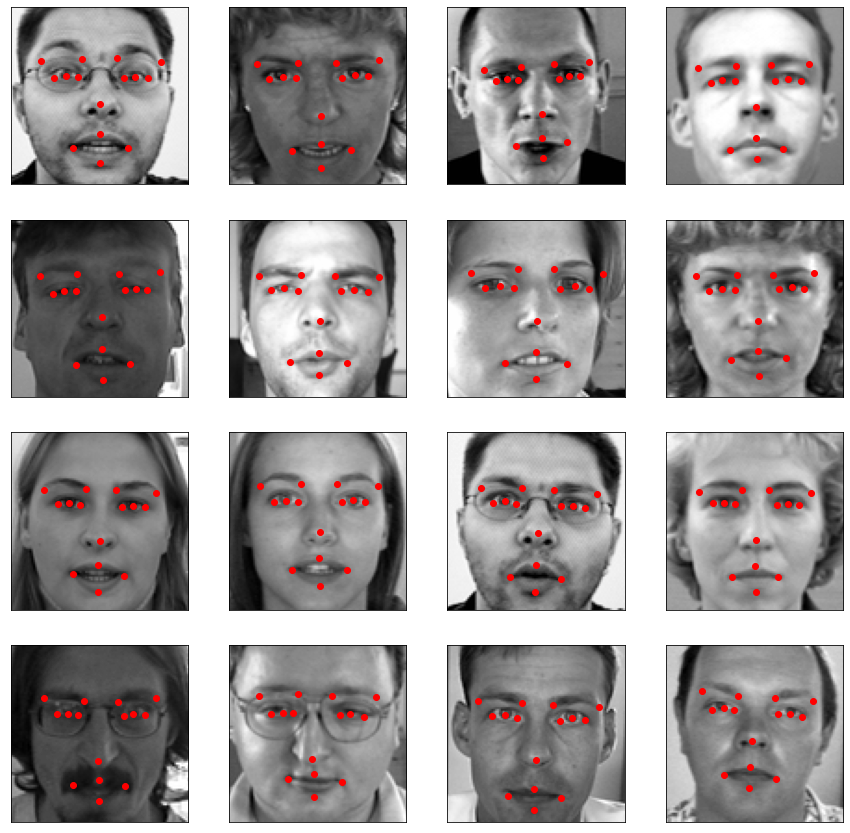

In [15]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))
print(points_test[0])
print(np.squeeze(points_test[0]))

for i in range(16):
    # ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [16]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
iii, ppp = load_data("./training/training.csv")

In [56]:
       
def augmentation_flip(imgs: np.ndarray, points: np.ndarray):
    # 翻轉圖片
    origin_imgs = imgs.copy()
    # print("origin_imgs min:", origin_imgs[:, :, :].min())
    flip_imgs = imgs[:, :, ::-1]
    new_imgs = np.vstack([origin_imgs, flip_imgs])
    # print(origin_imgs.shape)
    # print(new_imgs.shape)
    
    
    # 更改關鍵點的座標位置(左右替換)
    origin_points = np.copy(points)
    print(origin_points)
    # print("max: ", origin_points[:, :].max())  -> max: 0.49801022
    flip_points = points
    
    # 把 x 項的座標點加負號讓座標點水平翻轉
    for i in range(0,30,2):
        flip_points[:, i] = -points[:, i]

        
    # 更換label的index值(ex: 左眼的index改為右眼的index)
    flip_points_temp = np.copy(flip_points)
    flip_points[:, 0:2] = flip_points_temp[:, 2:4]
    flip_points[:, 2:4] = flip_points_temp[:, 0:2]
    flip_points[:, 4:6] = flip_points_temp[:, 8:10]
    flip_points[:, 6:8] = flip_points_temp[:, 10:12]
    flip_points[:, 8:10] = flip_points_temp[:, 4:6]
    flip_points[:, 10:12] = flip_points_temp[:, 6:8]
    flip_points[:, 12:14] = flip_points_temp[:, 16:18]
    flip_points[:, 14:16] = flip_points_temp[:, 18:20]
    flip_points[:, 16:18] = flip_points_temp[:, 12:14]
    flip_points[:, 18:20] = flip_points_temp[:, 14:16]
    flip_points[:, 22:24] = flip_points_temp[:, 24:26]
    flip_points[:, 24:26] = flip_points_temp[:, 22:24]
    
        
    new_points = np.vstack([origin_points, flip_points])
        
    return new_imgs, new_points

[[ 0.17767763 -0.1363579  -0.17808554 ...  0.23116446 -0.00755262
   0.31936842]
 [ 0.17943478 -0.11185655 -0.16642609 ...  0.23012179  0.03709567
   0.31529564]
 [ 0.18784958 -0.09372631 -0.18513533 ...  0.25974435 -0.05072179
   0.38006014]
 ...
 [ 0.21282154 -0.09737527 -0.19900149 ...  0.32336593 -0.00857565
   0.43275547]
 [ 0.16825181 -0.18029591 -0.21874064 ...  0.32605654  0.1105321
   0.3370369 ]
 [ 0.19462246 -0.14079762 -0.17932823 ...  0.29128742  0.05128509
   0.36105275]]
(4280, 96, 96) (4280, 30)


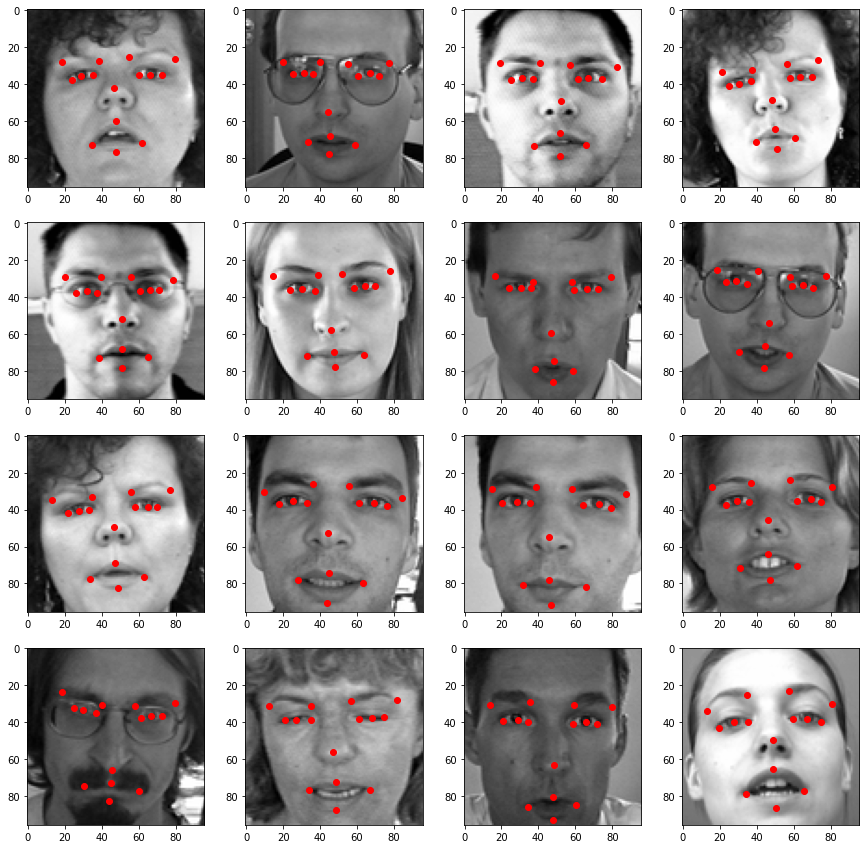

In [57]:
new_imgs, new_points = augmentation_flip(iii, ppp)
print(new_imgs.shape, new_points.shape)

fig = plt.figure(figsize=(15,15))
count = 0
for i in range(16):
        start_index = 500
        img_index = start_index + count
        ax = fig.add_subplot(4, 4, i + 1)
        # ax.imshow(imgs[i], cmap="gray")
        plot_keypoints(new_imgs[img_index], (new_points[img_index]))
        count += 1

In [58]:
img_flip, point_flip = augmentation_flip(iii, ppp)
print(img_flip.shape, point_flip.shape)

model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
# training the model
hist_model_aug = model_with_augment.fit(img_flip.reshape(img_flip.shape[0], 96, 96, 1), point_flip, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=20, verbose=1)


[[ 0.17808554 -0.1363579  -0.17767763 ...  0.23116446  0.00755262
   0.31936842]
 [ 0.16642609 -0.11185655 -0.17943478 ...  0.23012179 -0.03709567
   0.31529564]
 [ 0.18513533 -0.12060753 -0.18784958 ...  0.25974435  0.05072179
   0.38006014]
 ...
 [ 0.19900149 -0.10815597 -0.21282154 ...  0.32336593  0.00857565
   0.43275547]
 [ 0.21874064 -0.07429084 -0.16825181 ...  0.32605654 -0.1105321
   0.3370369 ]
 [ 0.17932823 -0.09813607 -0.19462246 ...  0.29128742 -0.05128509
   0.36105275]]
(4280, 96, 96) (4280, 30)
Epoch 1/20
54/54 [==============================] - 21s 330ms/step - loss: 0.0114 - val_loss: 0.0017

Epoch 00001: val_loss improved from inf to 0.00166, saving model to best_weights_augment.h5
Epoch 2/20
54/54 [==============================] - 17s 325ms/step - loss: 0.0016 - val_loss: 0.0016

Epoch 00002: val_loss improved from 0.00166 to 0.00163, saving model to best_weights_augment.h5
Epoch 3/20
54/54 [==============================] - 20s 364ms/step - loss: 0.0013 - val_los

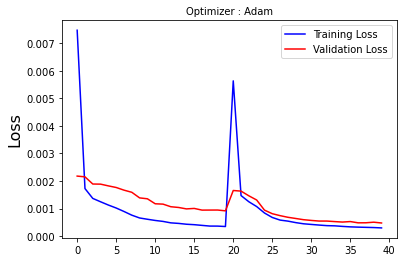

In [59]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

[ 0.19420376 -0.11712632 -0.19527584 -0.11698677  0.12954645 -0.10954913
  0.25620523 -0.10881357 -0.1347994  -0.11054046 -0.26294464 -0.10466931
  0.08525819 -0.2216599   0.33731675 -0.2032985  -0.09977283 -0.2172616
 -0.33454555 -0.2022568  -0.01352252  0.04342163  0.15199684  0.29167348
 -0.1628604   0.2914573  -0.01052394  0.2056396  -0.00879124  0.39117196]
[ 0.19420376 -0.11712632 -0.19527584 -0.11698677  0.12954645 -0.10954913
  0.25620523 -0.10881357 -0.1347994  -0.11054046 -0.26294464 -0.10466931
  0.08525819 -0.2216599   0.33731675 -0.2032985  -0.09977283 -0.2172616
 -0.33454555 -0.2022568  -0.01352252  0.04342163  0.15199684  0.29167348
 -0.1628604   0.2914573  -0.01052394  0.2056396  -0.00879124  0.39117196]


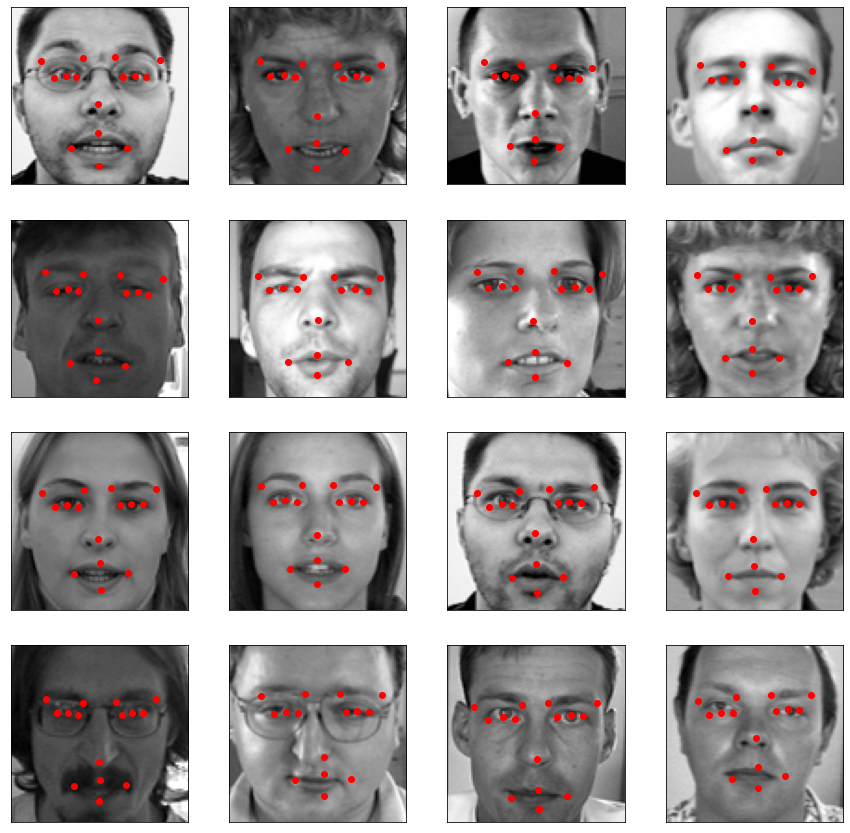

In [61]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))
print(points_test[0])
print(np.squeeze(points_test[0]))

for i in range(16):
    # ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))